<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%2011/extras/s11_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-bejn5ak1
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-bejn5ak1
     |████████████████████████████████| 634kB 4.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=c17ed3185a460cb4ee826321ec66788fa3d0c8ada8d18c441b3c0a39907db7f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-8siq6bbs/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=2a7252e8eb2dd77c51fc925b8caf56f0c1c336d774d8db16924ac00197ba0b80
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva_files'
sys.path.append(folder)

In [0]:
%matplotlib inline
import torch
import data_loading
import show_images
import dnn_architecture
import train_and_test
import evaluate
import gradcam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
import albumentations as A
import cv2
train_aug = [ 
             A.PadIfNeeded(min_height=36, min_width=36, p=1.0),
              A.RandomCrop(32, 32, always_apply=False, p=1.0),
              A.HorizontalFlip(),
              A.Cutout(num_holes=2, max_h_size=8,max_w_size = 8,p=1,fill_value=0.5*255), 
              A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),]

classes, trainloader, testloader = data_loading.load(train_augmentation = train_aug,mode='default_test_aug',gpu_batch_size=512)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([512, 3, 32, 32])
  cat truck truck   cat


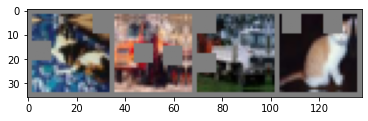

In [0]:
show_images.show_random_images(trainloader, classes)

In [0]:
import matplotlib.pyplot as plt

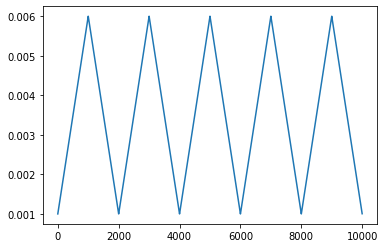

In [0]:
# Sample cyclic lr code :

import matplotlib.pyplot as plt
import numpy as np
def CyclicLR(num_iterations,base_lr,max_lr,step_size):
  l_rate =[]
  for iteration in range(num_iterations):
    cycle = np.floor(1+iteration/(2*step_size))
    x = np.abs(iteration/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    l_rate.append(lr)
  plt.plot(list(range(num_iterations)),l_rate)

CyclicLR(num_iterations=10000,base_lr=0.001, max_lr=0.006,step_size=1000)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnn_architecture.New_Resnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

range test for lr 0.1 - 0.0001

In [0]:
lrs = [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
      0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
      0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

trainAcc = []
testAcc = []
trainLoss = []
testLoss = []

for lr in lrs:
  epoch=0
  optimizer.param_groups[0]['lr'] = lr
  print('LR:',optimizer.param_groups[0]['lr'])

  train_test = train_and_test.Train_test()
  train_acc,train_acc_epoch_end,train_losses,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
  
  trainAcc.append(train_acc_epoch_end[0])
  testAcc.append(test_acc[0])
  trainLoss.append(train_losses[0])
  testLoss.append(test_losses[0])

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = dnn_architecture.New_Resnet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)




  0%|          | 0/98 [00:00<?, ?it/s]

LR: 0.0001


Loss=1.9315869808197021 Batch_id=97 Accuracy=22.13: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 3181/10000 (31.81%)

LR: 0.0002


Loss=1.729673147201538 Batch_id=97 Accuracy=27.50: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 3898/10000 (38.98%)

LR: 0.0003


Loss=1.6850179433822632 Batch_id=97 Accuracy=29.74: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4184/10000 (41.84%)

LR: 0.0004


Loss=1.6082518100738525 Batch_id=97 Accuracy=31.64: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4362/10000 (43.62%)

LR: 0.0005


Loss=1.5491503477096558 Batch_id=97 Accuracy=33.57: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4633/10000 (46.33%)

LR: 0.0006


Loss=1.5236952304840088 Batch_id=97 Accuracy=35.23: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4708/10000 (47.08%)

LR: 0.0007


Loss=1.4955710172653198 Batch_id=97 Accuracy=36.29: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4822/10000 (48.22%)

LR: 0.0008


Loss=1.4732680320739746 Batch_id=97 Accuracy=36.24: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 4772/10000 (47.72%)

LR: 0.0009


Loss=1.5827609300613403 Batch_id=97 Accuracy=37.11: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5018/10000 (50.18%)

LR: 0.001


Loss=1.4284032583236694 Batch_id=97 Accuracy=38.33: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5229/10000 (52.29%)

LR: 0.002


Loss=1.202986240386963 Batch_id=97 Accuracy=41.49: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5477/10000 (54.77%)

LR: 0.003


Loss=1.2526066303253174 Batch_id=97 Accuracy=43.60: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5710/10000 (57.10%)

LR: 0.004


Loss=1.3376127481460571 Batch_id=97 Accuracy=41.38: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5491/10000 (54.91%)

LR: 0.005


Loss=1.2336481809616089 Batch_id=97 Accuracy=43.24: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5282/10000 (52.82%)

LR: 0.006


Loss=1.2679531574249268 Batch_id=97 Accuracy=43.02: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5923/10000 (59.23%)

LR: 0.007


Loss=1.5816282033920288 Batch_id=97 Accuracy=33.82: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4629/10000 (46.29%)

LR: 0.008


Loss=1.5849723815917969 Batch_id=97 Accuracy=27.40: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4001/10000 (40.01%)

LR: 0.009


Loss=1.7685914039611816 Batch_id=97 Accuracy=21.28: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 3252/10000 (32.52%)

LR: 0.01


Loss=1.6401009559631348 Batch_id=97 Accuracy=24.64: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 3818/10000 (38.18%)

LR: 0.02


Loss=3.0543816089630127 Batch_id=97 Accuracy=13.69: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 1712/10000 (17.12%)

LR: 0.03


Loss=4.709609508514404 Batch_id=97 Accuracy=12.97: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 1652/10000 (16.52%)

LR: 0.04


Loss=2.424896240234375 Batch_id=97 Accuracy=12.68: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 1951/10000 (19.51%)

LR: 0.05


Loss=2.7349984645843506 Batch_id=97 Accuracy=10.96: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 1005/10000 (10.05%)

LR: 0.06


Loss=2.212512493133545 Batch_id=97 Accuracy=12.09: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 1524/10000 (15.24%)

LR: 0.07


Loss=3.140777587890625 Batch_id=97 Accuracy=10.21: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 1078/10000 (10.78%)

LR: 0.08


Loss=2.2605319023132324 Batch_id=97 Accuracy=11.49: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 1214/10000 (12.14%)

LR: 0.09


Loss=2.3035731315612793 Batch_id=97 Accuracy=10.24: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 1024/10000 (10.24%)

LR: 0.1


Loss=2.335190773010254 Batch_id=97 Accuracy=11.13: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0048, Accuracy: 1242/10000 (12.42%)



In [0]:
print('Train acc: ',max(trainAcc),'LR: ',lrs[trainAcc.index(max(trainAcc))])
print('Test acc: ',max(testAcc),'LR: ',lrs[testAcc.index(max(testAcc))])

Train acc:  43.602 LR:  0.003
Test acc:  59.23 LR:  0.006


Text(0, 0.5, 'Train Accuracy')

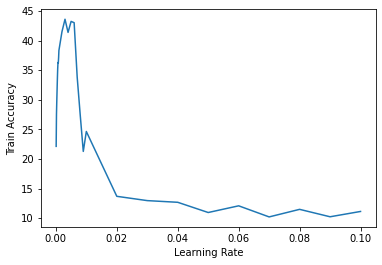

In [0]:
import matplotlib.pyplot as plt
plt.plot(lrs,trainAcc)
plt.xlabel('Learning Rate')
plt.ylabel('Train Accuracy')

Text(0, 0.5, 'Test Accuracy')

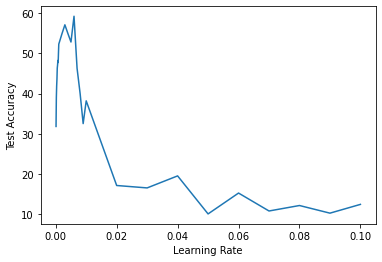

In [0]:
plt.plot(lrs,testAcc)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')

In [0]:
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
import torch.optim as optim

  
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = dnn_architecture.New_Resnet().to(device)

EPOCHS = 24
lr = 0.007
max_lr = 0.007

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr, total_steps=EPOCHS, epochs=None, steps_per_epoch=None,
                       pct_start=0.217, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85,
                       max_momentum=0.95, div_factor=8.0, final_div_factor=8.0, last_epoch=-1)

l_rate = []

train_test = train_and_test.Train_test()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'])    
    train_acc,train_acc_epoch_end,train_losses,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step()
    if epoch == 5 and test_acc[-1]<70:
      break
    if epoch == 10 and test_acc[-1]<80:
      break
    if epoch == 15 and test_acc[-1]<85 :
      break


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.000875


Loss=1.4190212488174438 Batch_id=97 Accuracy=38.26: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5173/10000 (51.73%)

EPOCH: 2 LR: 0.002330560836501901


Loss=1.1323411464691162 Batch_id=97 Accuracy=55.06: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6322/10000 (63.22%)

EPOCH: 3 LR: 0.003786121673003802


Loss=0.9369317889213562 Batch_id=97 Accuracy=63.33: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6822/10000 (68.22%)

EPOCH: 4 LR: 0.005241682509505703


Loss=0.8411989808082581 Batch_id=97 Accuracy=69.07: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7316/10000 (73.16%)

EPOCH: 5 LR: 0.006697243346007604


Loss=0.7633358836174011 Batch_id=97 Accuracy=72.49: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7367/10000 (73.67%)

EPOCH: 6 LR: 0.00670959051724138


Loss=0.8253437280654907 Batch_id=97 Accuracy=76.46: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7490/10000 (74.90%)

EPOCH: 7 LR: 0.006342911877394636


Loss=0.5566162467002869 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7987/10000 (79.87%)

EPOCH: 8 LR: 0.005976233237547893


Loss=0.44504982233047485 Batch_id=97 Accuracy=81.55: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8245/10000 (82.45%)

EPOCH: 9 LR: 0.00560955459770115


Loss=0.5023627877235413 Batch_id=97 Accuracy=83.85: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8114/10000 (81.14%)

EPOCH: 10 LR: 0.005242875957854406


Loss=0.3782590925693512 Batch_id=97 Accuracy=85.10: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8449/10000 (84.49%)

EPOCH: 11 LR: 0.004876197318007663


Loss=0.3602621555328369 Batch_id=97 Accuracy=86.56: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8495/10000 (84.95%)

EPOCH: 12 LR: 0.00450951867816092


Loss=0.4214414358139038 Batch_id=97 Accuracy=87.73: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8525/10000 (85.25%)

EPOCH: 13 LR: 0.0041428400383141765


Loss=0.3780725598335266 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8543/10000 (85.43%)

EPOCH: 14 LR: 0.0037761613984674336


Loss=0.2974586486816406 Batch_id=97 Accuracy=89.77: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8570/10000 (85.70%)

EPOCH: 15 LR: 0.0034094827586206903


Loss=0.27983060479164124 Batch_id=97 Accuracy=90.78: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8643/10000 (86.43%)

EPOCH: 16 LR: 0.003042804118773947


Loss=0.23770688474178314 Batch_id=97 Accuracy=91.29: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8726/10000 (87.26%)

EPOCH: 17 LR: 0.002676125478927204


Loss=0.231591135263443 Batch_id=97 Accuracy=92.05: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8713/10000 (87.13%)

EPOCH: 18 LR: 0.00230944683908046


Loss=0.19565702974796295 Batch_id=97 Accuracy=92.73: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8785/10000 (87.85%)

EPOCH: 19 LR: 0.0019427681992337164


Loss=0.16849297285079956 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8850/10000 (88.50%)

EPOCH: 20 LR: 0.0015760895593869744


Loss=0.1683887541294098 Batch_id=97 Accuracy=93.72: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8847/10000 (88.47%)

EPOCH: 21 LR: 0.0012094109195402306


Loss=0.1641361266374588 Batch_id=97 Accuracy=94.26: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8867/10000 (88.67%)

EPOCH: 22 LR: 0.0008427322796934859


Loss=0.20069734752178192 Batch_id=97 Accuracy=94.53: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8883/10000 (88.83%)

EPOCH: 23 LR: 0.0004760536398467439


Loss=0.17357444763183594 Batch_id=97 Accuracy=94.98: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8890/10000 (88.90%)

EPOCH: 24 LR: 0.0001093750000000001


Loss=0.1853616088628769 Batch_id=97 Accuracy=95.02: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.0007, Accuracy: 8902/10000 (89.02%)



In [0]:
print(l_rate)
l_rate.index(max(l_rate))

[0.000875, 0.002330560836501901, 0.003786121673003802, 0.005241682509505703, 0.006697243346007604, 0.00670959051724138, 0.006342911877394636, 0.005976233237547893, 0.00560955459770115, 0.005242875957854406, 0.004876197318007663, 0.00450951867816092, 0.0041428400383141765, 0.0037761613984674336, 0.0034094827586206903, 0.003042804118773947, 0.002676125478927204, 0.00230944683908046, 0.0019427681992337164, 0.0015760895593869744, 0.0012094109195402306, 0.0008427322796934859, 0.0004760536398467439, 0.0001093750000000001]


5

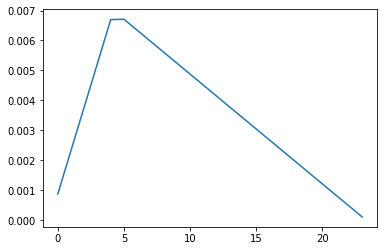

In [0]:
plt.plot(l_rate)

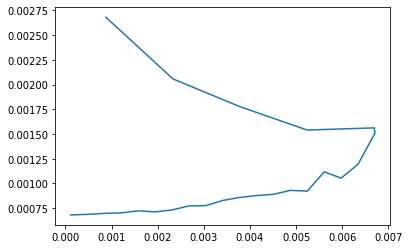

In [0]:
plt.plot(l_rate,test_losses)

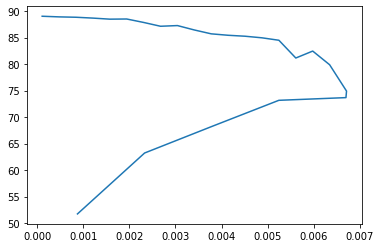

In [0]:
plt.plot(l_rate,test_acc)

In [0]:
len(test_acc)

24

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 10
lr = 0.00005
max_lr = lr

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=False, 
                              threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.0001, eps=1e-08)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])  
    l_rate.append(optimizer.param_groups[0]['lr'])
    train_acc,train_acc_epoch_end,train_losses,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step(test_losses[-1])
    
    if epoch == 1 and test_acc[-1]<20 :
      break
    if epoch == 6 and test_acc[-1]<89 :
      break



  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 5e-05


Loss=0.14164435863494873 Batch_id=97 Accuracy=95.16: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8909/10000 (89.09%)

EPOCH: 2 LR: 5e-05


Loss=0.15011189877986908 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8898/10000 (88.98%)

EPOCH: 3 LR: 5e-05


Loss=0.18302248418331146 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8914/10000 (89.14%)

EPOCH: 4 LR: 5e-05


Loss=0.13012434542179108 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8908/10000 (89.08%)

EPOCH: 5 LR: 5e-05


Loss=0.13930416107177734 Batch_id=97 Accuracy=95.23: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8909/10000 (89.09%)

EPOCH: 6 LR: 5e-05


Loss=0.16847477853298187 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8912/10000 (89.12%)

EPOCH: 7 LR: 5e-05


Loss=0.1454578936100006 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [00:21<00:00,  4.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8913/10000 (89.13%)

EPOCH: 8 LR: 5e-05


Loss=0.16982096433639526 Batch_id=97 Accuracy=95.41: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8910/10000 (89.10%)

EPOCH: 9 LR: 5e-05


Loss=0.13029392063617706 Batch_id=97 Accuracy=95.22: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8914/10000 (89.14%)

EPOCH: 10 LR: 5e-05


Loss=0.10554187744855881 Batch_id=97 Accuracy=95.53: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.0007, Accuracy: 8921/10000 (89.21%)



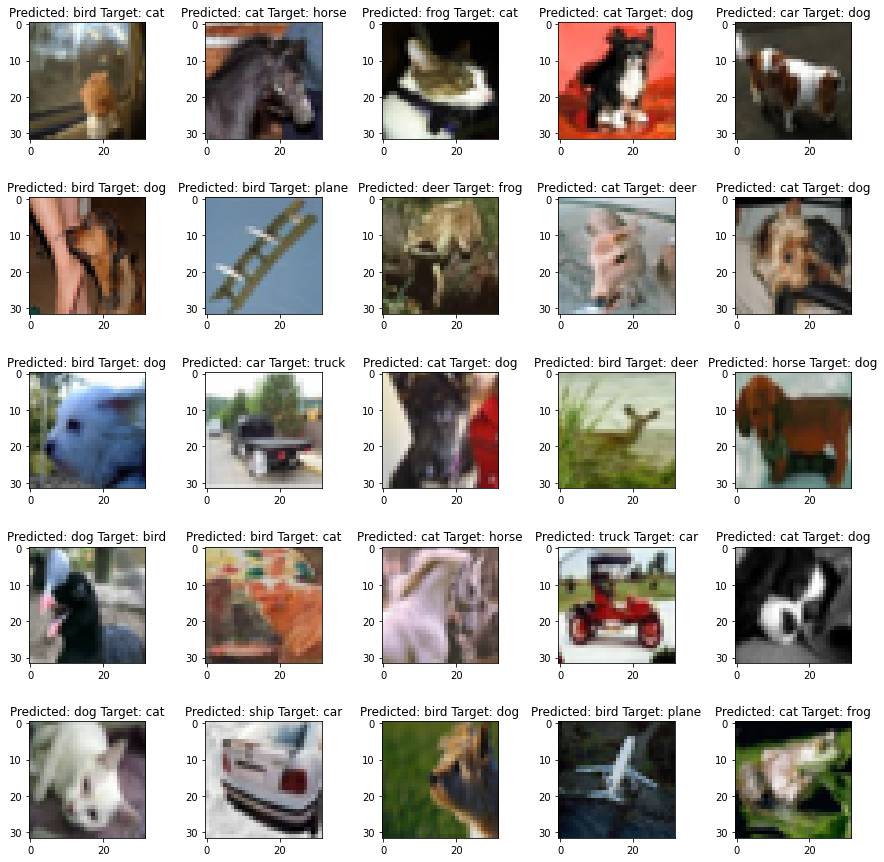

In [0]:
misclassify = show_images.show_misclassified_images(model, device, testloader,classes,num=25)

In [0]:
len(misclassify[1])

1079

GroundTruth:  plane  deer   car   dog   cat
Predicted:  plane  deer   car   dog   cat


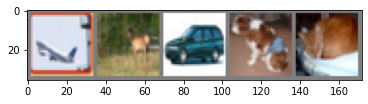

In [0]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [0]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 89 %


In [0]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 80 %
Accuracy of  bird : 72 %
Accuracy of   cat : 50 %
Accuracy of  deer : 83 %
Accuracy of   dog : 87 %
Accuracy of  frog : 75 %
Accuracy of horse : 90 %
Accuracy of  ship : 100 %
Accuracy of truck : 71 %


In [0]:
model

New_Resnet(
  (prepLayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cmbr_block1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (res_block1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): 

In [0]:
model.res_block2[0]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

/content/gdrive/My Drive/Colab Notebooks/eva_files/gradcam.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw={'xticks': [], 'yticks': []})


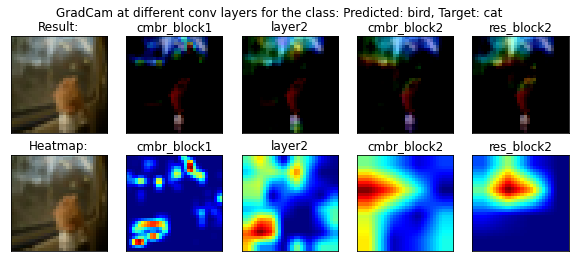

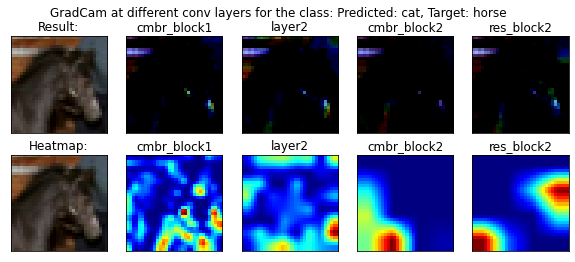

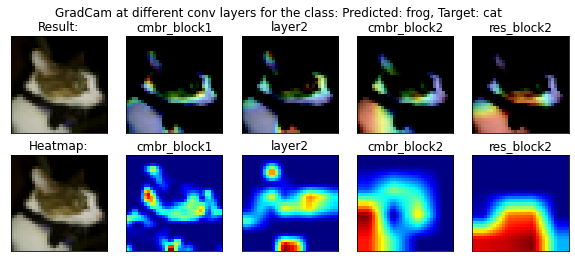

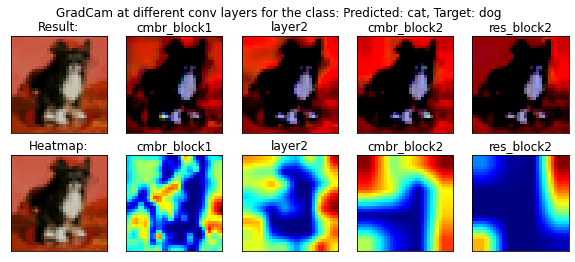

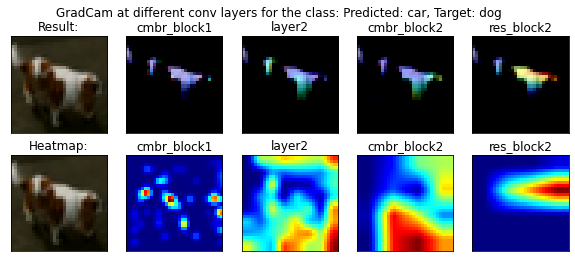

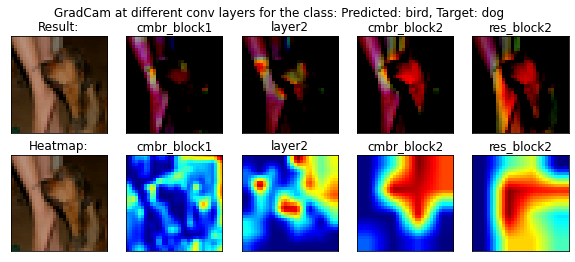

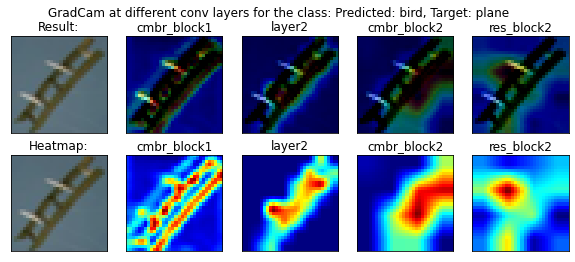

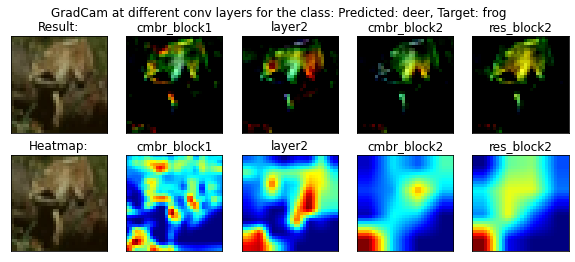

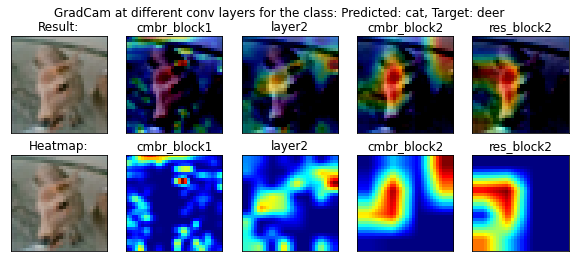

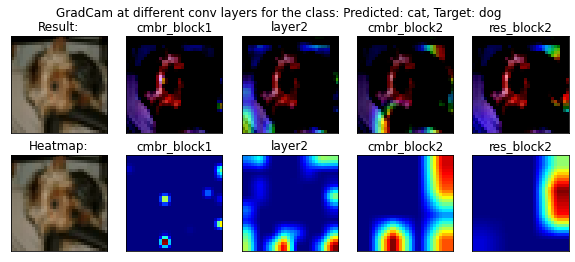

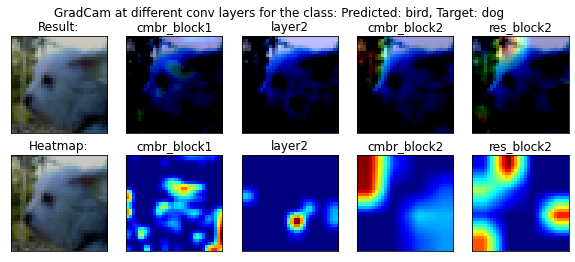

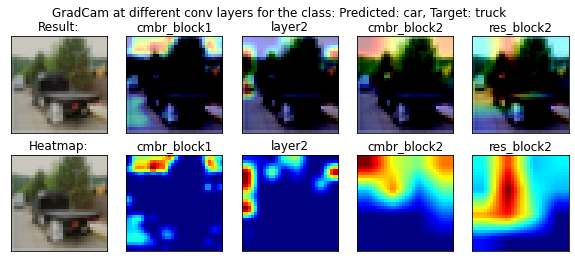

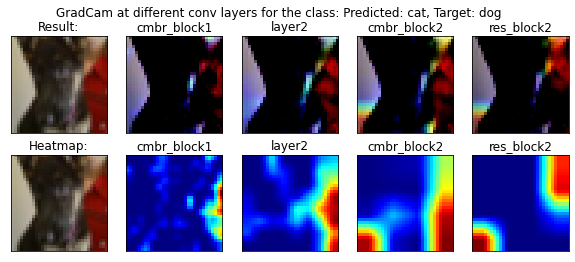

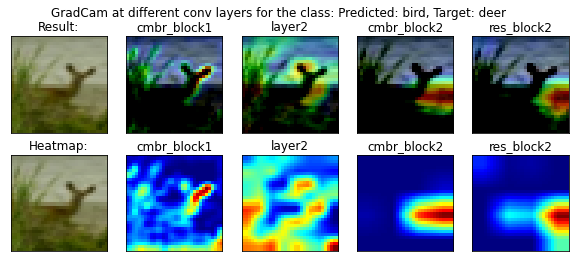

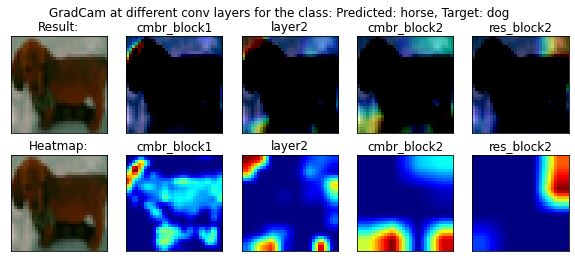

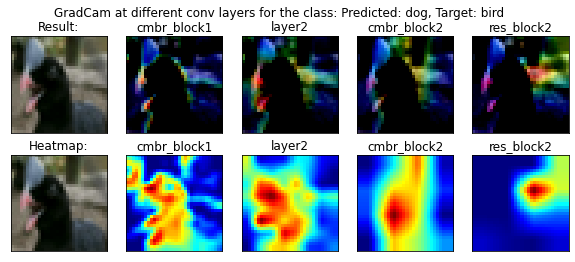

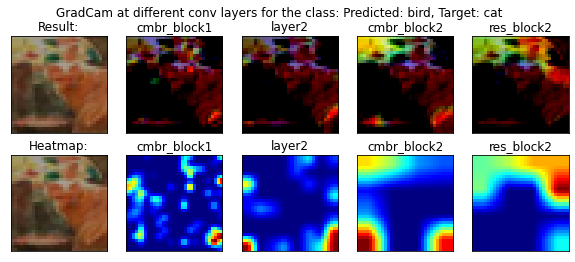

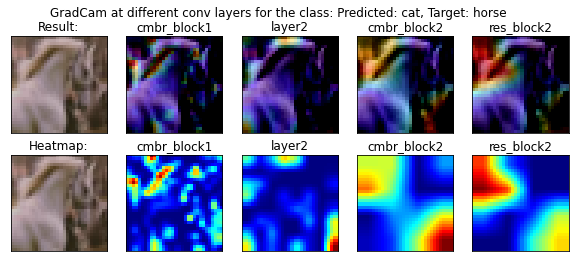

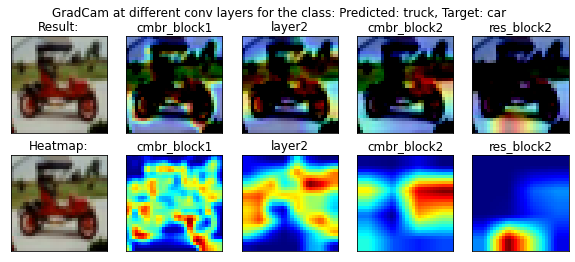

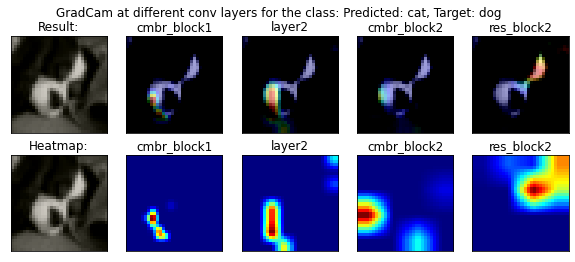

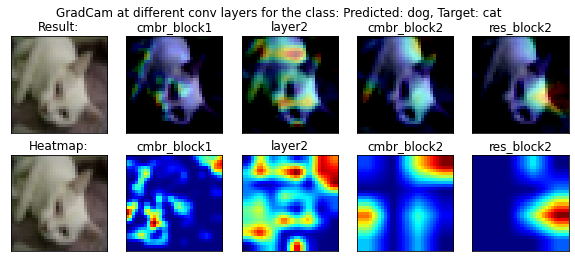

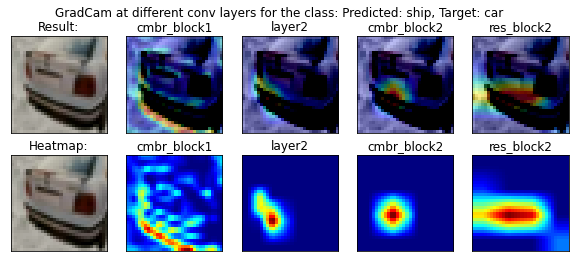

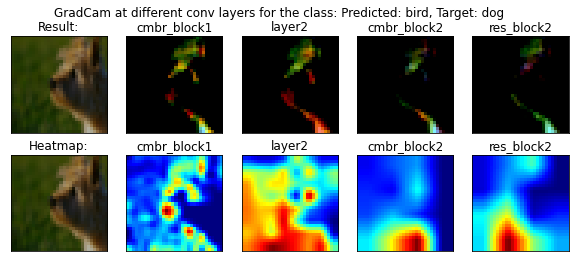

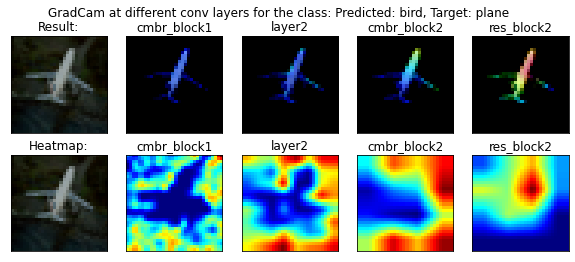

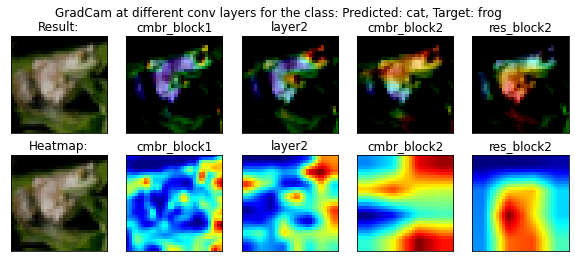

In [0]:
images=[]

for i in range(25):
  images.append(misclassify[0][i]*2-0.5)

target_layers = ["cmbr_block1","layer2","cmbr_block2","res_block2"]
gradcam = gradcam.VisualizeCam(model,classes, target_layers)
gradcam(torch.stack(images), target_layers,target_class=misclassify[2],pred=misclassify[1],num=25,name='misclassify')